# cost-related metrics based on Huawei cloud data

Data comes from Huawei FusionSolar and corresponds to one particular household

In [1]:
import pandas as pd
import numpy as np
import functionsCost as ff
import matplotlib.pyplot as plt

#to reload all changed modules every time before executing a new line
%load_ext autoreload
%autoreload 2

# Data read and checks

In [2]:
filename = 'NE=34145276.csv'
raw = pd.read_csv(filename)
raw.columns

Index(['batteryEnergy', 'gridABWireVoltage', 'batterySOC', 'grid2loadEnergy',
       'gridBPhaseVoltage', 'loadEnergy', 'gridAPhaseVoltage',
       'grid2batteryEnergy', 'chargeEnergy', 'pvEnergy', 'gridCAWireVoltage',
       'gridBCWireVoltage', 'ongridEnergy', 'dataTime', 'inputEnergy',
       'dischargeEnergy', 'gridCPhaseVoltage', 'pv2loadEnergy'],
      dtype='object')

In [3]:
print(f"nans {raw['batteryEnergy'].isna().sum()}"); raw['batteryEnergy'].describe()
#batteryEnergy = capacity*SOC(state of charge)*SOH(state of health); 
#due to istallation issues is usually missing;
#can be used to calculate recent max capacity; 

nans 230


count    8698.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: batteryEnergy, dtype: float64

In [4]:
raw = raw[['dataTime',
           'inputEnergy','ongridEnergy',
           'loadEnergy','pvEnergy',
           'chargeEnergy','dischargeEnergy','batterySOC']]
raw.isna().sum()

dataTime           0
inputEnergy        0
ongridEnergy       0
loadEnergy         0
pvEnergy           0
chargeEnergy       0
dischargeEnergy    0
batterySOC         0
dtype: int64

In [5]:
raw['data_time'] = pd.DatetimeIndex(raw['dataTime'])
raw = raw.set_index('data_time').drop(columns=['dataTime']).rename_axis(None).sort_index()
raw 
#according to documentation all energy is measured in kWh
#note data is cumulative, i.e. gradually increases in time (or stay constant)

,inputEnergy,ongridEnergy,loadEnergy,pvEnergy,chargeEnergy,dischargeEnergy,batterySOC
2023-01-01 00:00:00+02:00,5231.95,6978.02,7712.43,9458.50,0.00,0.00,15.0
2023-01-01 00:05:00+02:00,5231.99,6978.02,7712.46,9458.49,0.00,0.00,15.0
2023-01-01 00:10:00+02:00,5232.04,6978.02,7712.50,9458.48,0.00,0.00,15.0
2023-01-01 00:15:00+02:00,5232.08,6978.02,7712.54,9458.48,0.00,0.00,15.0
2023-01-01 00:20:00+02:00,5232.12,6978.02,7712.57,9579.21,3921.16,3800.42,15.0
...,...,...,...,...,...,...,...
2023-01-31 23:35:00+02:00,5780.68,6986.02,8233.78,9564.01,3941.54,3816.65,16.0
2023-01-31 23:40:00+02:00,5780.72,6986.02,8233.82,9564.01,3941.54,3816.65,16.0
2023-01-31 23:45:00+02:00,5780.75,6986.02,8233.84,9439.11,0.00,0.00,16.0
2023-01-31 23:50:00+02:00,5780.79,6986.02,8233.87,9439.10,0.00,0.00,16.0


In [6]:
print(f"Are all timestamps present? {raw.shape[0]==(raw.index==pd.date_range(start=raw.index[0], end=raw.index[-1], freq='5min')).sum()}")

Are all timestamps present? True


# Remove disconnections

As we know from previos investigations, pv, charge and discharge energies experience some strange "disconnections". Below we put interpolated data instead of disconnections

In [7]:
rawInter = ff.removeDisconnections(raw)

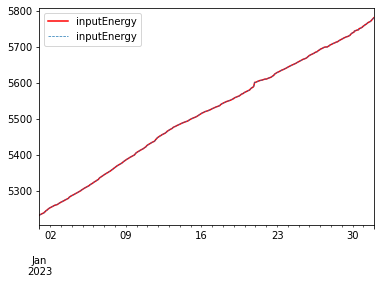

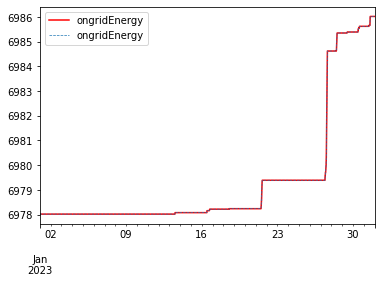

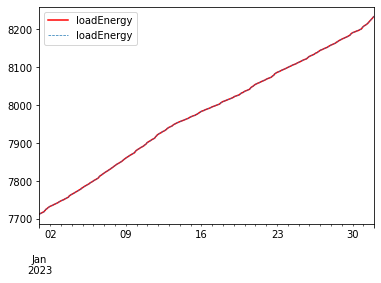

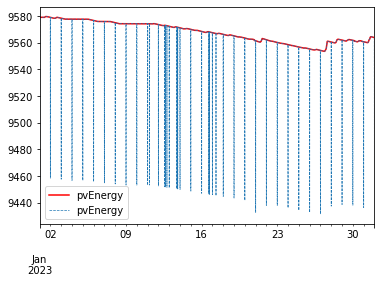

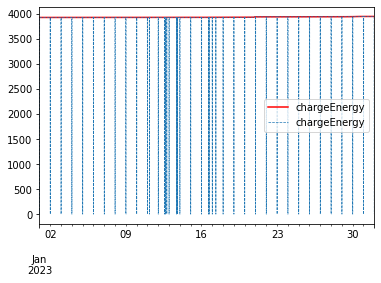

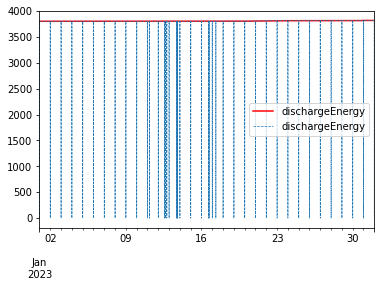

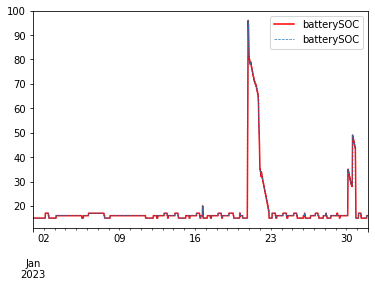

In [8]:
for c in rawInter.columns[:-1]:
    ax=rawInter[[c]].plot(color='r')
    raw[[c]].plot(ls='--',lw=0.7,ax=ax)

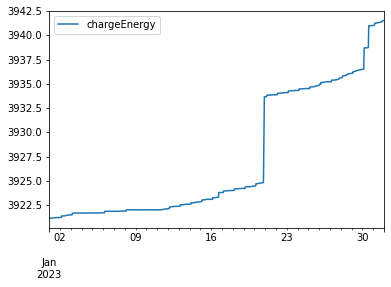

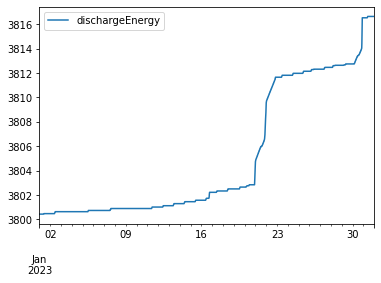

In [9]:
rawInter.plot(y='chargeEnergy')
rawInter.plot(y='dischargeEnergy');

## From cumulative to diffirentiated values

In [10]:
diff = ff.differentiate(rawInter.copy(deep=True)) 
#differentiated data; cumulative amount during 5min interval starting from datetime 

In [11]:
dd = ff.addBalanceCol(diff) 
dd.describe().round(5)
#balance between incoming and outcoming energy flows is missing

,inputEnergy,ongridEnergy,loadEnergy,pvEnergy,chargeEnergy,dischargeEnergy,batterySOC,disconnected,incoming-outcoming
count,8927.00000,8927.00000,8927.00000,8927.00000,8927.00000,8927.00000,8927.00000,8927.00000,8927.00000
mean,0.06149,0.00090,0.05842,-0.00170,0.00228,0.00182,0.00011,0.05131,0.00001
std,0.05481,0.01013,0.04754,0.01738,0.02492,0.01117,0.28342,0.30133,0.00158
min,0.00000,0.00000,-0.01000,-0.14000,0.00000,0.00000,-5.00000,0.00000,-0.08000
25%,0.02000,0.00000,0.02000,-0.01000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.04000,0.00000,0.04000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,0.10000,0.00000,0.10000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,0.57000,0.25000,0.33000,0.31000,0.47000,0.34000,4.00000,2.00000,0.08000


In [12]:
dd[dd['disconnected']==0].describe().round(5) 
#balance between incoming and outcoming energy flows is there if no disconnections are present
#note also possible negative pvEnergy (see min) 
#this points to the fact that pv consumes energy (visible when generation from sun is zero)

,inputEnergy,ongridEnergy,loadEnergy,pvEnergy,chargeEnergy,dischargeEnergy,batterySOC,disconnected,incoming-outcoming
count,8657.00000,8657.00000,8657.00000,8657.00000,8657.00000,8657.00000,8657.00000,8657.0,8657.0
mean,0.06144,0.00092,0.05843,-0.00158,0.00233,0.00182,0.00058,0.0,0.0
std,0.05496,0.01029,0.04750,0.01763,0.02529,0.01129,0.28660,0.0,0.0
min,0.00000,0.00000,-0.01000,-0.14000,0.00000,0.00000,-5.00000,0.0,-0.0
25%,0.02000,0.00000,0.02000,-0.01000,0.00000,0.00000,0.00000,0.0,0.0
50%,0.04000,0.00000,0.04000,0.00000,0.00000,0.00000,0.00000,0.0,0.0
75%,0.10000,0.00000,0.10000,0.00000,0.00000,0.00000,0.00000,0.0,0.0
max,0.57000,0.25000,0.33000,0.31000,0.47000,0.34000,4.00000,0.0,0.0


# aggregating into hour resolution

In [13]:
diff.columns

Index(['inputEnergy', 'ongridEnergy', 'loadEnergy', 'pvEnergy', 'chargeEnergy',
       'dischargeEnergy', 'batterySOC', 'disconnected'],
      dtype='object')

In [14]:
diffHourly = ff.aggHourly(diff[diff.columns[:-1]])
diffHourly

,inputEnergy,ongridEnergy,loadEnergy,pvEnergy,chargeEnergy,dischargeEnergy,batterySOC
2023-01-01 00:00:00,1.00,0.0,0.92,-0.05,0.00,0.0,0.0
2023-01-01 01:00:00,0.42,0.0,0.42,0.00,0.00,0.0,0.0
2023-01-01 02:00:00,0.83,0.0,0.83,0.00,0.00,0.0,0.0
2023-01-01 03:00:00,0.32,0.0,0.32,0.00,0.00,0.0,0.0
2023-01-01 04:00:00,0.85,0.0,0.85,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...
2023-01-31 18:00:00,1.32,0.0,1.24,-0.07,0.01,0.0,0.0
2023-01-31 19:00:00,1.43,0.0,1.27,-0.11,0.05,0.0,0.0
2023-01-31 20:00:00,1.63,0.0,1.47,-0.12,0.04,0.0,0.0
2023-01-31 21:00:00,1.67,0.0,1.55,-0.09,0.03,0.0,1.0


In [15]:
ff.addBalanceCol(diffHourly).describe().round(5) 
#in hourly resolution the balance is missing as well

,inputEnergy,ongridEnergy,loadEnergy,pvEnergy,chargeEnergy,dischargeEnergy,batterySOC,incoming-outcoming
count,743.00000,743.00000,743.00000,743.00000,743.00000,743.00000,743.00000,743.00000
mean,0.73822,0.01077,0.70144,-0.02040,0.02742,0.02184,0.00135,0.00004
std,0.43629,0.11260,0.32971,0.18674,0.25759,0.11299,2.63989,0.00512
min,0.00000,0.00000,0.18000,-0.44000,0.00000,0.00000,-22.00000,-0.07500
25%,0.50000,0.00000,0.46000,-0.08000,0.00000,0.00000,0.00000,-0.00000
50%,0.69000,0.00000,0.67000,-0.07000,0.00000,0.00000,0.00000,0.00000
75%,0.90500,0.00000,0.88000,0.00000,0.01000,0.00000,0.00000,0.00000
max,5.73000,2.02000,2.27000,2.71000,4.43000,2.10000,42.00000,0.07500


# battery capacity
we can estimate battery max capacity by calculating amount of kW related to 1% of SOC. We calculate difference delta=chargeEnergy-dischargeEnergy and compare this with relevant SOC

In [16]:
dd = diffHourly[['batterySOC','chargeEnergy','dischargeEnergy']].copy(deep=True)
dd['delta'] = dd['chargeEnergy'] - dd['dischargeEnergy']

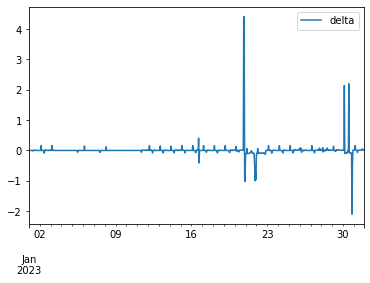

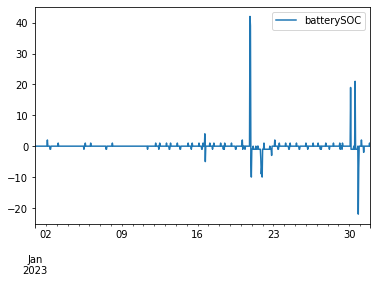

In [17]:
dd[['delta']].plot()
dd[['batterySOC']].plot();

In [18]:
dd['kW in 1%'] = dd['delta']/dd['batterySOC']

In [19]:
dd.replace([np.inf, -np.inf], np.nan, inplace=True) #replace \pm inf with NaN

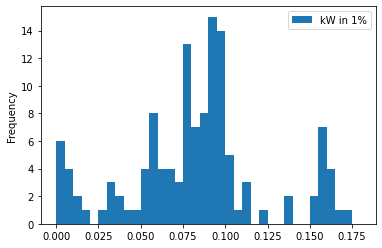

In [20]:
dd[['kW in 1%']][dd['kW in 1%'].notna()].plot(kind='hist',bins=36,range=[0,0.18]);

We see "kW in 1%" values have peaked distribution.

In [21]:
print(f"mean kW in 1% {dd['kW in 1%'][dd['kW in 1%'].notna()].mean():.3f}\nmedian kW in 1% {dd['kW in 1%'][dd['kW in 1%'].notna()].median():.3f}")

mean kW in 1% 0.081
median kW in 1% 0.082


In [22]:
print(f"kW in 1% based on large chargings {dd[ dd['delta'].abs()> dd['delta'].mean()+3*dd['delta'].std() ]['kW in 1%'].mean():.3f}")

kW in 1% based on large chargings 0.105


In [23]:
batteryCapacity = 10 #kW; 
#estimated based on large chargings; 
#in plant_info file capacity=6.48

# household electricity cost (downstream metric) as it is without any optimization
This is what meter point calculates based on inputEnergy cost and ongridEnergy cost 

For downstream metric we use small dataset

In [24]:
dd = rawInter[['batterySOC']].rename(columns={'batterySOC':'rawBatterySOC'})
dd.index = pd.DatetimeIndex(dd.index.strftime('%Y-%m-%d %H:%M:%S'))

In [25]:
price = ff.preprocessPrice('price.csv')  #in Euro/kWh
diffData = pd.concat([diffHourly,dd,price],axis=1,join='inner').sort_index()

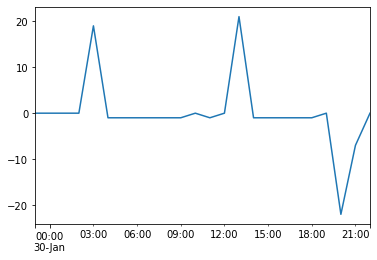

In [26]:
ind, interval = -48, 24
diffDataTest = diffData[ind:(ind+interval)]
diffDataTest['batterySOC'].plot();
# we play with this interval, becouse it contains user-defined operations with battery

In [27]:
diffDataTest.head(7)

,inputEnergy,ongridEnergy,loadEnergy,pvEnergy,chargeEnergy,dischargeEnergy,batterySOC,rawBatterySOC,price
2023-01-29 23:00:00,0.81,0.0,0.73,-0.075,0.01,0.00,0.0,16.0,0.02508
2023-01-30 00:00:00,0.35,0.0,0.27,-0.065,0.01,0.00,0.0,16.0,0.01834
2023-01-30 01:00:00,0.80,0.0,0.71,-0.080,0.01,0.00,0.0,16.0,0.01309
2023-01-30 02:00:00,0.37,0.0,0.29,-0.080,0.00,0.00,0.0,16.0,0.00576
2023-01-30 03:00:00,3.08,0.0,0.61,-0.330,2.19,0.05,19.0,16.0,0.00495
2023-01-30 04:00:00,0.19,0.0,0.18,-0.110,0.00,0.10,-1.0,35.0,0.00405
2023-01-30 05:00:00,0.63,0.0,0.62,-0.100,0.00,0.09,-1.0,34.0,0.00903


Note that here batterySOC is amount of SOC (in %) transfered into the battery during NEXT hour; but rawBatterySOC is SOC value in the battery (in %) in the BEGINNING of the hour 

### Buy/sell price issue
For private clients buying price includes market price + 20% tax (käibemaks) + 7 cents/kwh (other taxes and net cost).
For selling: market price - 1 cent/kwh.

Buying and selling price difference may more than 100% if market price is low.

In [28]:
percent = 0.02
buyExtra = 0.00 #Eur/kwh to add to buying price
sellExtra = -0.00 #Eur/kwh to add to selling price

In [29]:
par = {'percent':percent, 'buyExtra':buyExtra, 'sellExtra':sellExtra}

#household cost due to difference between inputEnergy*buyPrice and ongridEnergy*sellPrice
print(ff.costDefault(diffDataTest,par)['message'])

cost 1.078 Euro
input cost 1.100 Euro
ongrid gain 0.022 Euro


# household electricity cost when battery is disabled (switched off or absent)
- Each moment of time, we need to have balance between incoming=input+pv+discharge and outcoming=ongrid+load+charge energy flows: incoming=outcoming
- If at some moment we register delta=discharge-charge>0, then in the absense of the battery the household needs incoming extra energy equals to delta. This incoming extra can only to be bought from the grid  
- If at some moment we register delta=discharge-charge<0, then in the absense of the battery the household needs more outcoming extra energy equals to delta. This outcoming extra can be 1) sold to the grid 2) used to reduce input energy  
- there is third option to calculate cost without battery: find load-pv, is it>0 buy from grid, if it<0 sell to grid

In [30]:
print(ff.costNoBattery(diffDataTest,par)[0]['message'])

cost 1.199 Euro
input cost 1.444 Euro
ongrid gain 0.245 Euro


In [31]:
print(ff.costNoBattery(diffDataTest,par)[1]['message'])

cost 1.195 Euro
input cost 1.217 Euro
ongrid gain 0.022 Euro


In [32]:
print(ff.costNoBattery(diffDataTest,par)[2]['message'])

cost 1.195 Euro
input cost 1.199 Euro
ongrid gain 0.004 Euro


i.e. without battery we buy and sell more grid energy (case 1)!

Note that case 2 is better because buying energy is more expensive than selling! In addition, the is a casuality issue: if there is outcoming extra we wont buy extra rather then sell it. Note also that 2nd approach assumes that **without battery the pattern for load, pv and ongrid remain the same** as was with battery.    

There is 3rd approch: calculate load-pv, when it is positive we buy this amount, otherwise we sell it. In this case **without battery the pattern for load and pv remains the same** as was with battery, however input and ongrid change!

# household electricity cost when battery usage is governed by optimizer

The idea to use optimizer is the following: we want to optimize future battery charge/discharge behaviour in order to have lowest electricity cost. For future we dont know the load and pv. Therefore we will *predict* these timeseries. Based on the *predicted* load and pv, the optimizer will find the battery behaviour. Then we force the client to follow battery behaviour found. This behavior together with *real* load and pv will form the electricity cost for the household.  

## Precalculations to show that optimizer output is driven by predicted load

Piece of theory. Each moment of time we have the balance $$input_i+pv_i+discharge_i=charge_i+ongrid_i+load_i$$  

Lets assume we buy for $price+\Delta$ and sell for $price$. Optimizer wants to make $$F=\sum_i[input_i(price_i+\Delta_i)-ongrid_i\cdot price_i]$$
as small/negative as possible. By using balance Eq. we rewrite $F$ as 
$$F=\sum_i(charge_i-discharge_i+load_i-pv_i)price_i+\sum_iinput_i\cdot \Delta_i=$$
$$=\sum_i(charge_i-discharge_i)price_i+\sum_i(load_i-pv_i)price_i+\sum_iinput_i\cdot \Delta_i$$  
When price difference is absent, $\Delta_i=0$, optimizer deals with the first term only, making $charge_i-discharge_i$ be synced with $price_i$ in a way to minimize this term. The second term is totally user defined and optimizer cannot change it. Therefore in $\Delta_i=0$ case the charge-discharge pattern *does not depend on load and pv* at all.

Situation changes when $\Delta_i\neq0$. In this case optimizer is able to minimize $F$ by mininizing the combination of the first and the third term. It is the third term, which makes optimizer to take $load$ and $pv$ into account. 

Lets check this hypothesis.

Here we provide 24 values and inspect optimizer output. 


In [33]:
params={
    'capacity': batteryCapacity,
    'chargePower': 5,
    'roundTripEfficiency': 1,
    'minAllowedChargeLevel': 0.2,
    'depreciation': 0.01,
    'maxCyclesPerPeriod': 1,
    'mainFuse': 16,
    'percent': percent,
    'buyExtra':buyExtra, 
    'sellExtra':sellExtra
}

### predictions by oracle

In [34]:
dd = diffDataTest.copy(deep=True).assign(predictedLoadEnergy=diffDataTest['loadEnergy'])

### predicted high load

In [35]:
totalLoad = dd['loadEnergy'].sum(); totalLoad

16.43000000000029

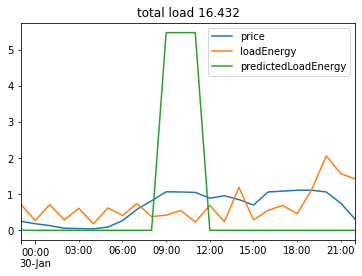

In [36]:
highLoad = list(np.repeat(0.0,10))+list(np.repeat(totalLoad/3,3))+  list(np.repeat(totalLoad/100000,11))#+ list(np.repeat(0.0,2))

ddHigh = dd.copy(deep=True).assign(predictedLoadEnergy=highLoad)

ddHigh.assign(price=ddHigh['price'].values*10)[['price','loadEnergy','predictedLoadEnergy']].plot(title=f"total load {np.sum(highLoad):.3f}");

### comparison for different params

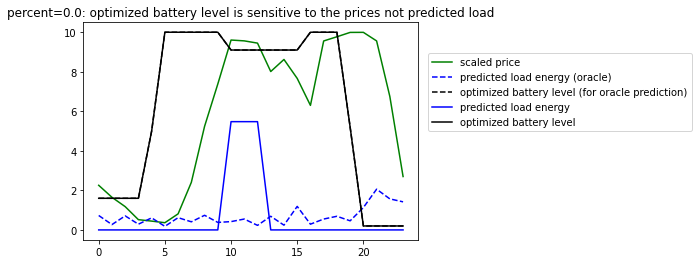

In [37]:
par = params.copy(); par['percent']=0.0
ff.compareBatteryEnergy(dd,ddHigh,par,title=f"percent={par['percent']}: optimized battery level is sensitive to the prices not predicted load")

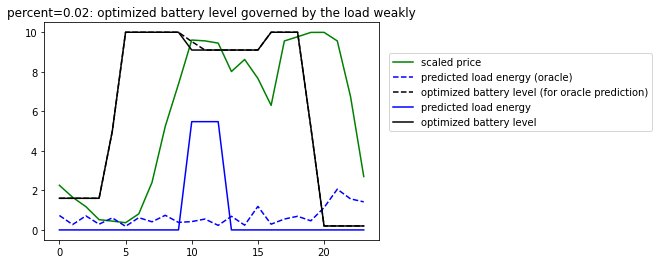

In [38]:
par = params.copy(); par['percent']=0.02
ff.compareBatteryEnergy(dd,ddHigh,par,title=f"percent={par['percent']}: optimized battery level governed by the load weakly")

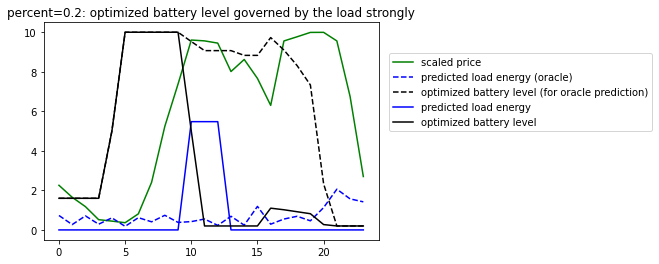

In [39]:
par = params.copy(); par['percent']=0.2
ff.compareBatteryEnergy(dd,ddHigh,par,title=f"percent={par['percent']}: optimized battery level governed by the load strongly")
#optimizer tells to use energy stored in the battery to cover expensive load; 
#then it speculates in price

In [40]:
par1 = params.copy(); par1['percent']=0.02
par2 = params.copy(); par2['percent']=0.2

f11 = ff.optimize1step(dd,par1,initialChargeLevel=dd['rawBatterySOC'].values[0]*0.01*par1['capacity'])
f21 = ff.optimize1step(ddHigh,par1,initialChargeLevel=ddHigh['rawBatterySOC'].values[0]*0.01*par1['capacity'])
f12 = ff.optimize1step(dd,par2,initialChargeLevel=dd['rawBatterySOC'].values[0]*0.01*par2['capacity'])
f22 = ff.optimize1step(ddHigh,par2,initialChargeLevel=ddHigh['rawBatterySOC'].values[0]*0.01*par2['capacity'])

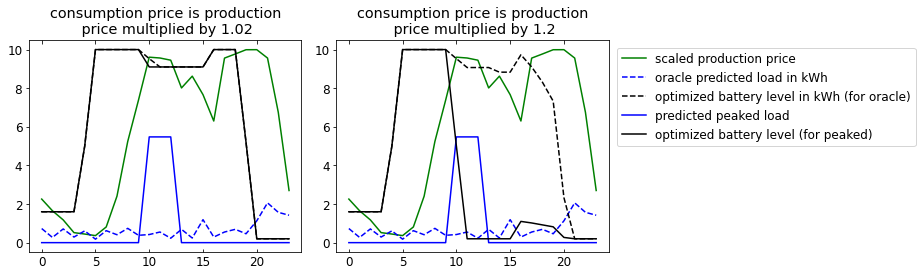

In [41]:
plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(13,4))
ax = axs[0]
ax.plot(dd['price'].values*90,label='scaled price',c='g')
ax.plot(dd['predictedLoadEnergy'].values,label='predicted load energy (oracle)',c='b',ls='--')
ax.plot(f11['output']['info']['bat_level'],label='optimized battery level (for oracle prediction)',c='k',ls='--')
ax.plot(ddHigh['predictedLoadEnergy'].values,label='predicted load energy',c='b')
ax.plot(f21['output']['info']['bat_level'],label='optimized battery level',c='k')
ax.legend(loc=(1.03, 0.5))
ax.set_title('consumption price is production\n price multiplied by 1.02');
ax.legend().set_visible(False)
ax.xaxis.set_tick_params(top=True,direction='in')


ax = axs[1]
ax.plot(dd['price'].values*90,label='scaled production price',c='g')
ax.plot(dd['predictedLoadEnergy'].values,label='oracle predicted load in kWh ',c='b',ls='--')
ax.plot(f12['output']['info']['bat_level'],label='optimized battery level in kWh (for oracle)',c='k',ls='--')
ax.plot(ddHigh['predictedLoadEnergy'].values,label='predicted peaked load',c='b')
ax.plot(f22['output']['info']['bat_level'],label='optimized battery level (for peaked)',c='k')
ax.legend(loc=(1.03, 0.5))
ax.set_title('consumption price is production\n price multiplied by 1.2')
ax.xaxis.set_tick_params(top=True,direction='in');


plt.tight_layout();
#plt.savefig('batLevel_price.eps', format='eps',dpi=200)

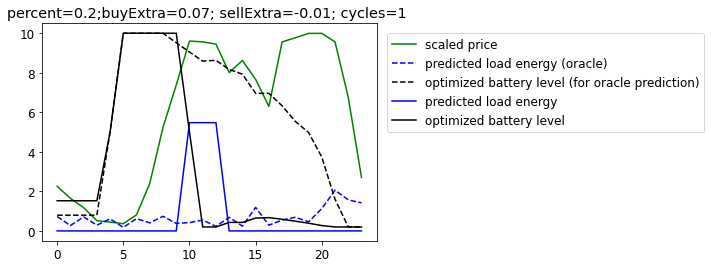

In [42]:
par = params.copy(); par['percent']=0.2; par['buyExtra']=0.07; par['sellExtra'] = -0.01
ff.compareBatteryEnergy(dd,ddHigh,par,title=f"percent={par['percent']};\
buyExtra={par['buyExtra']}; sellExtra={par['sellExtra']}; cycles={par['maxCyclesPerPeriod']} ")
#realistic scenario

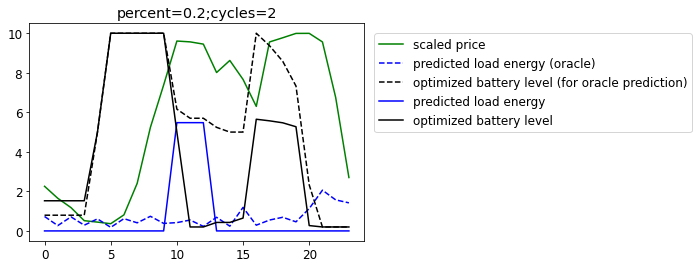

In [43]:
par = params.copy(); par['percent']=0.2; par['maxCyclesPerPeriod']=2
ff.compareBatteryEnergy(dd,ddHigh,par,title=f"percent={par['percent']};\
cycles={par['maxCyclesPerPeriod']}")
#when second cycle is allowed it is used to enhance speculation in price difference

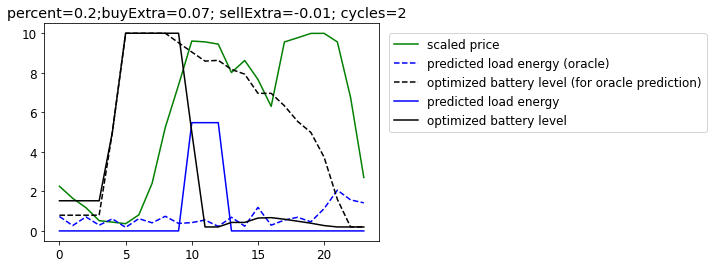

In [44]:
par = params.copy(); par['percent']=0.2; par['buyExtra']=0.07; par['sellExtra'] = -0.01; par['maxCyclesPerPeriod']=2
ff.compareBatteryEnergy(dd,ddHigh,par,title=f"percent={par['percent']};\
buyExtra={par['buyExtra']}; sellExtra={par['sellExtra']}; cycles={par['maxCyclesPerPeriod']}  ")
#this is realistic scenario, for some reason second strong peak for battery does not appear

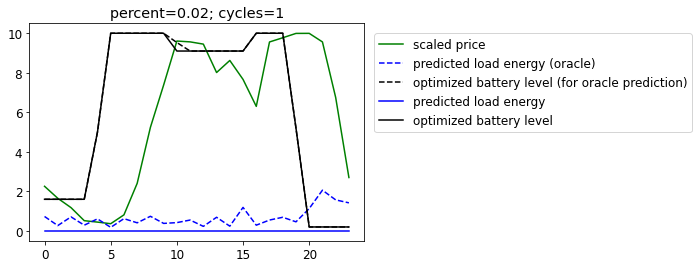

In [45]:
par = params.copy(); par['percent']=0.02; par['maxCyclesPerPeriod']=1
ff.compareBatteryEnergy(dd,
                        dd.copy(deep=True).assign(predictedLoadEnergy=0.0),
                        par,
                        title=f"percent={par['percent']}; cycles={par['maxCyclesPerPeriod']}")

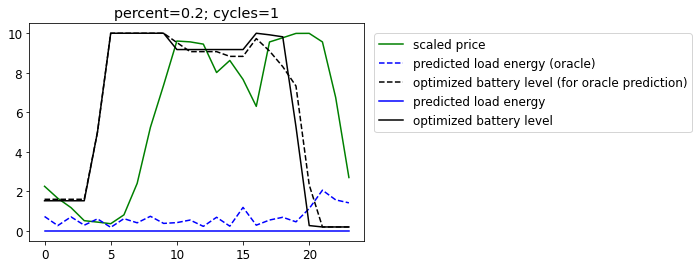

In [46]:
par = params.copy(); par['percent']=0.2; par['maxCyclesPerPeriod']=1
ff.compareBatteryEnergy(dd,
                        dd.copy(deep=True).assign(predictedLoadEnergy=0.0),
                        par,
                        title=f"percent={par['percent']}; cycles={par['maxCyclesPerPeriod']}")

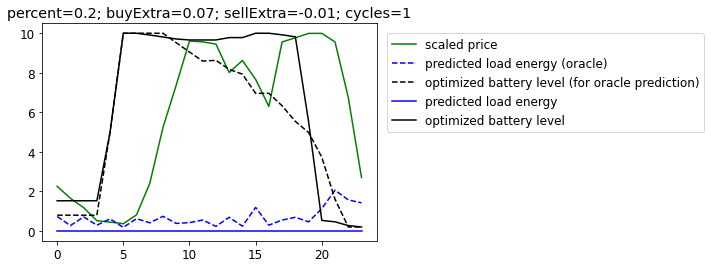

In [47]:
par = params.copy(); par['percent']=0.2; par['maxCyclesPerPeriod']=1
par['buyExtra']=0.07; par['sellExtra'] = -0.01;
ff.compareBatteryEnergy(dd,
                        dd.copy(deep=True).assign(predictedLoadEnergy=0.0),
                        par,
                        title=f"percent={par['percent']}; buyExtra={par['buyExtra']}; sellExtra={par['sellExtra']}; cycles={par['maxCyclesPerPeriod']}")

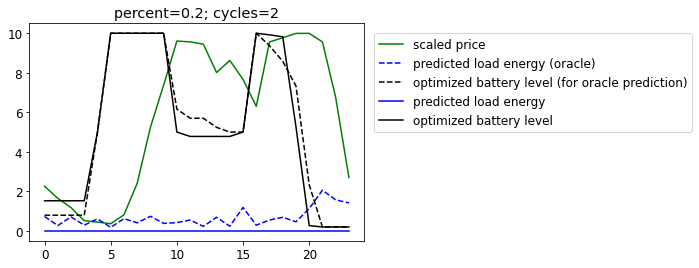

In [48]:
par = params.copy(); par['percent']=0.2; par['maxCyclesPerPeriod']=2
ff.compareBatteryEnergy(dd,
                        dd.copy(deep=True).assign(predictedLoadEnergy=0.0),
                        par,
                        title=f"percent={par['percent']}; cycles={par['maxCyclesPerPeriod']}")

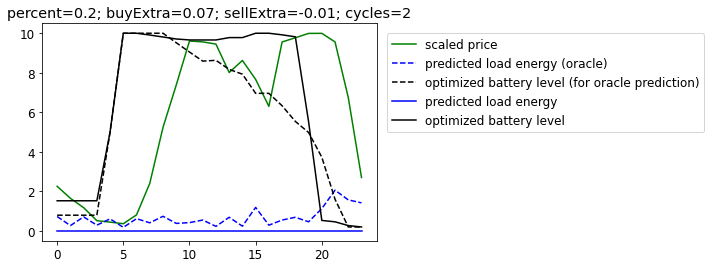

In [49]:
par = params.copy(); par['percent']=0.2; par['maxCyclesPerPeriod']=2
par['buyExtra']=0.07; par['sellExtra'] = -0.01;
ff.compareBatteryEnergy(dd,
                        dd.copy(deep=True).assign(predictedLoadEnergy=0.0),
                        par,
                        title=f"percent={par['percent']}; buyExtra={par['buyExtra']}; sellExtra={par['sellExtra']}; cycles={par['maxCyclesPerPeriod']}")

## Optimizing step by step
If optimizer sees 24h data, it means that optimizers "life" is limited to these 24h, i.e. optimizer thinks that after 24h nothing happens. This is not true. Next we optimize step by step: at each step we provide 24h-ahead data and one each step take only first oprimization value

### Oracle prediction

We optimize step by step providing each step 24h-ahead data. 

In [50]:
dd = diffData[-48:]
dd = dd.assign(predictedLoadEnergy=dd['loadEnergy'])
out24 = ff.optimize24steps(dd,params)

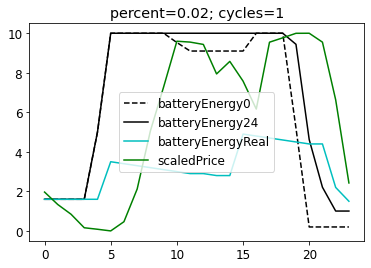

In [51]:
ff.vis1(out24)
#24step optimization differs from 1step optimization: note full discharge for 1 step case

We see that when we optimize according to single day, then the last hours are end of life for optimizer so that there is no need keep battery charged and all energy from the battery can be sold. However when we optimize hour by hour, optimizer knows that last hours are not the end of life (there are more 24 hours after last hour) so that it makes sense to keep some energy on the battery for future.

In [52]:
par = params.copy(); par['percent']=0.2
out24_per20 = ff.optimize24steps(dd,par)

In [53]:
out24_per20['input']

,inputEnergy,ongridEnergy,loadEnergy,pvEnergy,chargeEnergy,dischargeEnergy,batterySOC,rawBatterySOC,price,predictedLoadEnergy
2023-01-29 23:00:00,0.81,0.00,0.73,-0.075,0.010,0.00,0.0,16.0,0.02508,0.73
2023-01-30 00:00:00,0.35,0.00,0.27,-0.065,0.010,0.00,0.0,16.0,0.01834,0.27
2023-01-30 01:00:00,0.80,0.00,0.71,-0.080,0.010,0.00,0.0,16.0,0.01309,0.71
2023-01-30 02:00:00,0.37,0.00,0.29,-0.080,0.000,0.00,0.0,16.0,0.00576,0.29
2023-01-30 03:00:00,3.08,0.00,0.61,-0.330,2.190,0.05,19.0,16.0,0.00495,0.61
2023-01-30 04:00:00,0.19,0.00,0.18,-0.110,0.000,0.10,-1.0,35.0,0.00405,0.18
2023-01-30 05:00:00,0.63,0.00,0.62,-0.100,0.000,0.09,-1.0,34.0,0.00903,0.62
2023-01-30 06:00:00,0.41,0.00,0.41,-0.090,0.000,0.09,-1.0,33.0,0.02674,0.41
2023-01-30 07:00:00,0.75,0.00,0.74,-0.100,0.000,0.09,-1.0,32.0,0.05821,0.74
2023-01-30 08:00:00,0.40,0.00,0.38,-0.100,0.010,0.09,-1.0,31.0,0.08201,0.38


In [54]:
len(out24_per20['out0']['output']['variables']['charge'])

24

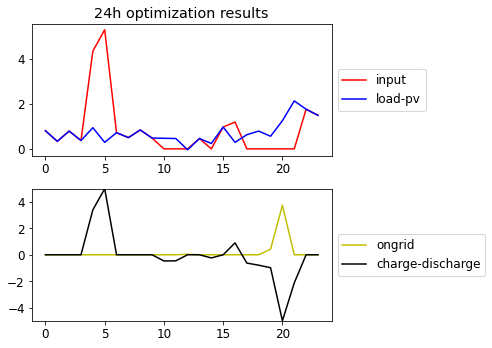

In [55]:

cc1 = ff.cost({'charge':out24_per20['out0']['output']['variables']['charge'],
                 'discharge':out24_per20['out0']['output']['variables']['discharge'],
                 'input': out24_per20['input'],
                 'params': out24_per20['params']}
               )
c1 = (cc1['data'][['inputOpt','ongridOpt','loadEnergy','pvEnergy','deltaOpt']]
 .rename(columns={'deltaOpt':'charge-discharge','inputOpt':'input','ongridOpt':'ongrid','loadEnergy':'load','pvEnergy':'pv'})
 .reset_index(drop=True))

c1['load-pv']=c1['load']-c1['pv']

plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(7,5))
ax = axs[0]
c1[['input','load-pv']].plot(color=['r','b'],ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('24h optimization results')
#ax.set_ylim(-1,6)

ax=axs[1]
c1[['ongrid','charge-discharge']].plot(color=['y','k'],ax=ax)
ax.set_ylim(-5,5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout();
#plt.savefig('optResults.eps', format='eps',dpi=200)